In [2]:
from pluribus.game.deck import Deck
from pluribus.game.evaluation import Evaluator
import numpy as np
from itertools import combinations
import math
import random
import time
import dill as pickle

import matplotlib.pyplot as plt

In [3]:
deck = Deck()
deck.shuffle()
# store as eval for faster evaluation
short_deck = [c.eval_card for c in deck[:10]]
eval_to_card = {i.eval_card:i for i in deck[:10]}
evaluator = Evaluator()

In [4]:
# need to figure out lossless for the deck, will substantially reduce combos: https://poker.cs.ualberta.ca/publications/2013-techreport-nl-size.pdf
# need to figure out how to efficeintly store these combos to get ehs
# do they use lossless even for bucketing?

In [5]:
def get_card_combos(num_cards, cards):
    """
    return combos of cards (Card.eval_card)
    """
    # most performant I could find so far
    return np.asarray(list(combinations(cards, num_cards)))

In [6]:
starting_hands = get_card_combos(2, short_deck)

In [7]:
flops = get_card_combos(3, short_deck)

In [8]:
turns_rivers = get_card_combos(1, short_deck)

In [9]:
# will not be good for whole deck, how to make better?
# thinking it's best to store as the first x, where x = starting hand plus community amount 
# then sample cards not in those for the opponent hand/turn & river
# would be nice to store those as well perhaps?
def create_card_combos(start_publics, add_publics):
    our_cards = []
    for start_public in start_publics:
        for add_public in add_publics:
            # skip if our any of previous cards are in the new ones
            if not np.any(np.isin(start_public, add_public)):
                # not np.any(np.isin(start_public, add_public)):
                our_cards.append(np.concatenate((start_public, add_public)))
    return np.array(our_cards)

In [10]:
on_flop = create_card_combos(starting_hands, flops)

In [11]:
on_turn = create_card_combos(on_flop, turns_rivers)

In [12]:
on_river = create_card_combos(on_turn, turns_rivers)

In [13]:
# check combos correct 

In [14]:
def ncr(n,r):
    """
    helper function for calculating combination size
    n choose r"""
    return int(math.factorial(n)/(math.factorial(r)*math.factorial(n-r)))

In [15]:
print(f'expected river: {ncr(10,2)*ncr(8,3)*ncr(5,1)*ncr(4,1)}')

expected river: 50400


In [16]:
print(f'my combos: {len(on_river)}')

my combos: 50400


In [17]:
ehss = [0]*len(on_river) # statts for expected hand strengths

In [18]:
# get data for expected hand rates on 5 card public board, not lossless

In [19]:
# even with lossless, we are looking at a lot of simulations.. hhow can we do this better? 
start = time.time()

for i, public in enumerate(on_river): 
    available_cards = [x for x in short_deck if x not in public]
    
    ehs = [0]*3
    for j in range(50): # probably want to increase this number?
        
        opp_hand = random.sample(available_cards, 2) # going to run into the same hand combos..
        our_hand = list(public[:2])
        board = list(public[2:7])
        
        our_hand_rank = evaluator.evaluate(
            board=board, # should this accept numpy array?
            cards=our_hand,
        )
        opp_hand_rank = evaluator.evaluate(
                board=board,
                cards=opp_hand,
        )
        
        # who wins?
        if our_hand_rank > opp_hand_rank: # maybe some mod magic here
            idx = 0
        elif our_hand_rank < opp_hand_rank:
            idx = 1
        elif our_hand_rank == opp_hand_rank:
            idx = 2
            
        # increment win rate for winner/tie
        ehs[idx] += 1/50
        
    ehss[i] = ehs
    
end = time.time()
print(end - start)

580.8873100280762


In [20]:
# simple kmeans algo - should I write from scratch?
# you might need to adjust the centers number since the deck is being shuffled if 
# you run it from the top, but you can also get the data out of the data folder
# no more than 20 clusters or graph won't work below, FYI
from sklearn.cluster import KMeans

X=np.array(ehss)

km = KMeans(
    n_clusters=15, init='random', # would be 200 in our example
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(X)

In [21]:
# centers to be used to get data for EMD
centroids = km.cluster_centers_

In [22]:
data = {
    'ehss_river': ehss,
    'short_deck': short_deck,
    'combos': [on_flop, on_turn, on_river],
    'river_centroids': centroids,
    'eval_to_card': eval_to_card
}

In [23]:
with open('data/ehss_river.pkl', 'wb') as file:
    pickle.dump(data, file)

In [24]:
# # to reopen
# with open('data/ehss_river.pkl', 'rb') as file:
#     data = pickle.load(file)

In [25]:
compare_hands = random.sample(list(on_river[y_km==4]), 5)

In [26]:
# taking a look at them
for games in compare_hands:
    t = [eval_to_card[x] for x in games.tolist()[:2]]
    print("####Hand")
    print(t)
    t = [eval_to_card[x] for x in games.tolist()[2:]]
    print("####Board")
    print(t)

####Hand
[<Card card=[ace of hearts ♥]>, <Card card=[8 of clubs ♣]>]
####Board
[<Card card=[8 of hearts ♥]>, <Card card=[ace of diamonds ♦]>, <Card card=[10 of clubs ♣]>, <Card card=[4 of hearts ♥]>, <Card card=[10 of diamonds ♦]>]
####Hand
[<Card card=[ace of spades ♠]>, <Card card=[8 of hearts ♥]>]
####Board
[<Card card=[3 of spades ♠]>, <Card card=[10 of clubs ♣]>, <Card card=[8 of clubs ♣]>, <Card card=[10 of diamonds ♦]>, <Card card=[ace of diamonds ♦]>]
####Hand
[<Card card=[ace of diamonds ♦]>, <Card card=[7 of clubs ♣]>]
####Board
[<Card card=[ace of spades ♠]>, <Card card=[8 of hearts ♥]>, <Card card=[10 of clubs ♣]>, <Card card=[10 of diamonds ♦]>, <Card card=[8 of clubs ♣]>]
####Hand
[<Card card=[ace of hearts ♥]>, <Card card=[3 of spades ♠]>]
####Board
[<Card card=[ace of spades ♠]>, <Card card=[10 of clubs ♣]>, <Card card=[10 of diamonds ♦]>, <Card card=[8 of clubs ♣]>, <Card card=[7 of clubs ♣]>]
####Hand
[<Card card=[ace of hearts ♥]>, <Card card=[8 of clubs ♣]>]
####Boa

In [27]:
# colors for plotting
colors = {
    0:'y', 
    1:'b', 
    2:'g',
    3:'r', 
    4:'c', 
    5:'m',
    6:'y', 
    7:'b', 
    8:'w',
    9:'#7A68A6',
    10:'#FFB5B8',
    11:'#fdb462',
    12:'#8b8b8b',
    13:'#bc82bd',
    14:'#8EBA42',
    15:'#467821',
    16:'#fdb462',
    17:'#30a2da',
    18:'#cbcbcb',
    19:'#b3de69',
    20:'#30a2da'
}

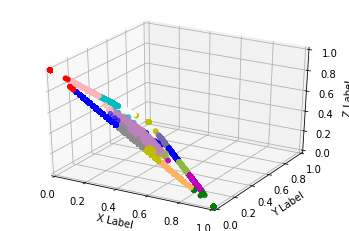

In [30]:
# a cute graph
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for m, zlow, zhigh in [('o', -50, -25), ('^', -30, -5)]:
    # plot the centroids   
    for i in range(20):
        ax.scatter(
        X[y_km==i, 0], X[y_km==i, 2], X[y_km==i, 1],
        s=20, marker='o',
        c=colors[i])
    
ax.set_zlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [29]:
# it's possible the authors ONLY used expected hand strength of the wins: https://poker.cs.ualberta.ca/publications/AAMAS13-abstraction.pdf
# we could try both and see what does better, might have to do just ehs for 6 player game